# Data analysis

In [112]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer

In [113]:
X_train = pd.read_csv('../data_students/labeled_data/X_train.csv')
X_test  = pd.read_csv('../data_students/labeled_data/X_test.csv')
y_train = pd.read_csv('../data_students/labeled_data/y_train.csv', header=None)
y_test  = pd.read_csv('../data_students/labeled_data/y_test.csv', header=None)

X_train = X_train.drop(columns=['img_filename'])
X_test  = X_test.drop(columns=['img_filename'])

y_train = y_train.squeeze()
y_test  = y_test.squeeze()

normally_distributed_categories=['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin', 'height', 'potassium', 'vitamin D', 'weight']
ordinal_categories = ['sarsaparilla', 'smurfberry liquor', 'smurfin donuts']
profession_categories = [['food production', 'administration and governance', 'services', 'ressource extraction', 'craftsmanship', 'manufacturing']]
_, number_features = X_train.shape
features_names = X_train.columns.tolist()

### Raw data analysis

In [114]:
X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1000 non-null   int64  
 1   blood pressure     1000 non-null   float64
 2   calcium            1000 non-null   float64
 3   cholesterol        1000 non-null   float64
 4   hemoglobin         1000 non-null   float64
 5   height             1000 non-null   float64
 6   potassium          1000 non-null   float64
 7   profession         1000 non-null   object 
 8   sarsaparilla       1000 non-null   object 
 9   smurfberry liquor  1000 non-null   object 
 10  smurfin donuts     1000 non-null   object 
 11  vitamin D          1000 non-null   float64
 12  weight             1000 non-null   float64
dtypes: float64(8), int64(1), object(4)
memory usage: 101.7+ KB


,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight
0,79,105.64,2.18,73.47,12.54,7.74,3.90,food production,Low,High,Moderate,27.04,92.79
1,73,94.72,2.68,100.56,12.61,7.73,4.53,food production,Low,Low,High,23.60,105.90
2,184,111.48,2.62,99.85,11.27,7.46,3.51,administration and governance,Very high,Moderate,Very low,29.89,92.37
3,90,99.58,2.74,124.83,14.71,7.45,3.78,administration and governance,Low,Moderate,High,31.41,112.15
4,150,114.41,2.62,129.22,13.39,7.81,3.13,services,Very low,Moderate,High,31.59,108.87


In [115]:
category = X_train['profession'].unique()
if X_train['profession'].isna().values.any():
    print('profession has missing values')
print(category)

category = X_train['sarsaparilla'].unique()
if X_train['sarsaparilla'].isna().values.any():
    print('sarsaparilla has missing values')
print(category)

category = X_train['smurfberry liquor'].unique()
if X_train['smurfberry liquor'].isna().values.any():
    print('smurfberry liquor has missing values')
print(category)

category = X_train['smurfin donuts'].unique()
if X_train['smurfin donuts'].isna().values.any():
    print('smurfin donuts has missing values')
print(category)

['food production' 'administration and governance' 'services'
 'ressource extraction' 'craftsmanship' 'manufacturing']
['Low' 'Very high' 'Very low' 'Moderate' 'High']
['High' 'Low' 'Moderate' 'Very low' 'Very high']
['Moderate' 'High' 'Very low' 'Very high' 'Low']


### Outliers

In [116]:
z_scores = np.abs(stats.zscore(X_train[normally_distributed_categories]))
outliers = np.where(z_scores > 3)
outlier_indices = np.unique(outliers[0])
print(f"Percentage of outliers (Z-score method): {len(outlier_indices) / X_train.shape[0] * 100:.2f}%")

Percentage of outliers (Z-score method): 3.00%


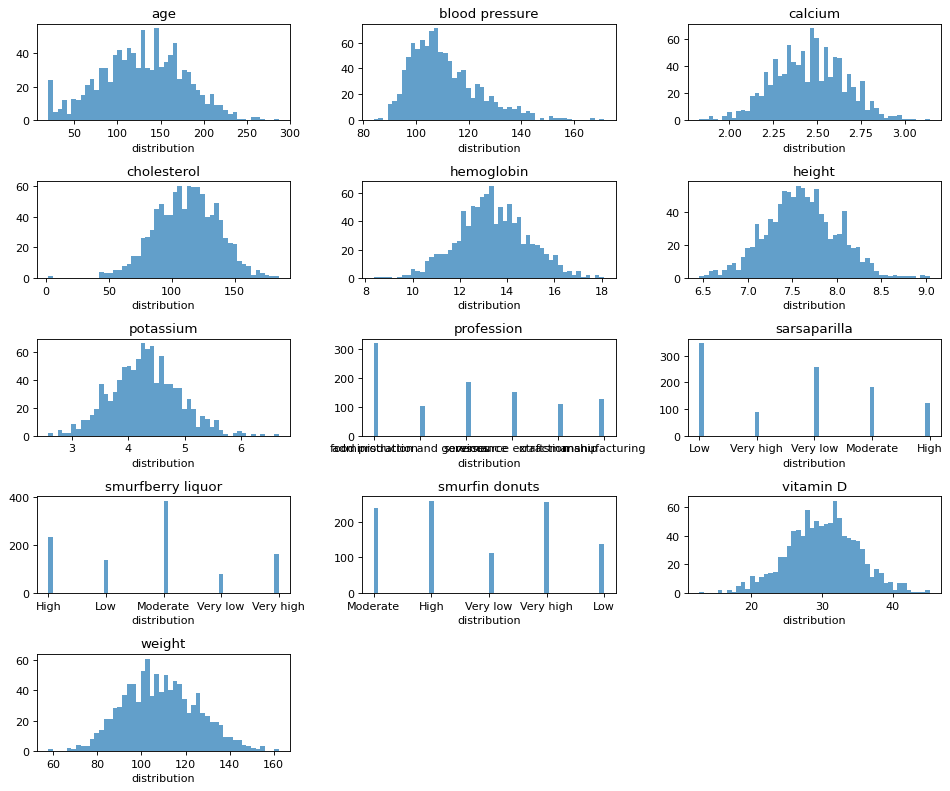

In [117]:
X_train.describe(percentiles=[0.05,0.95])
fig = plt.figure(figsize=(12, 10), dpi=80)

for i, idx in enumerate(range(number_features)):
    plt.subplot(number_features // 3 + 1, 3, i + 1)
    plt.hist(X_train.iloc[:, idx], bins=50, alpha=0.7)
    plt.xlabel("distribution")
    plt.title(f"{features_names[idx]}")

plt.tight_layout()
plt.show()

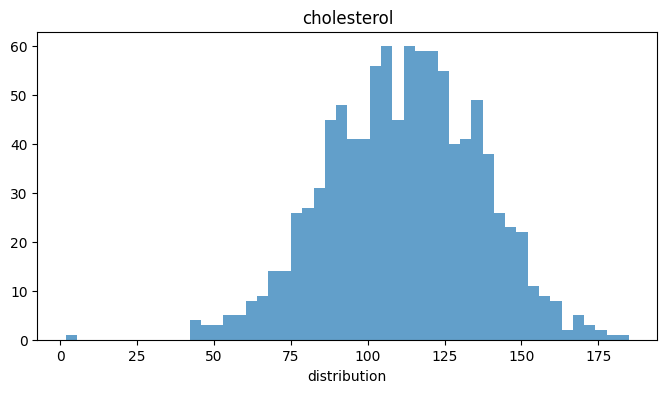

In [118]:
plt.figure(figsize=(8, 4))
plt.hist(X_train['cholesterol'], bins=50, alpha=0.7)
plt.xlabel("distribution")
plt.title(f"cholesterol")
plt.show()

In [119]:
cholesterol_indexes = X_train[X_train['cholesterol'] < 5].index
X_train = X_train.drop(cholesterol_indexes).reset_index(drop=True)
y_train = y_train.drop(cholesterol_indexes).reset_index(drop=True)
print(f"Dropping indexes: {cholesterol_indexes}")

Dropping indexes: Index([992], dtype='int64')


# Pre-processing and Standardization

### Ordinal encoding
Since sarsaparilla, smurfberry liquor and smurfin donuts have some ordinality (from very low to very high) we can transform it with values from 0 to 5.

In [120]:
ordinal_encoder = OrdinalEncoder(categories=[['Very low', 'Low', 'Moderate', 'High', 'Very high']])
for category in ordinal_categories:
    X_train[category] = ordinal_encoder.fit_transform(X_train[[category]])
    X_test[category]  = ordinal_encoder.transform(X_test[[category]])

### One-hot encoder for Profession category
We create a vector of values which are set to zeros except for the profession value of the item.

In [121]:
one_hot_encoder = OneHotEncoder(categories=profession_categories, sparse_output=False)

profession_encoded_train = one_hot_encoder.fit_transform(X_train[['profession']])
profession_encoded_train_df = pd.DataFrame(profession_encoded_train, columns=one_hot_encoder.get_feature_names_out(['profession']))
X_train = pd.concat([X_train.drop('profession', axis=1), profession_encoded_train_df], axis=1)

profession_encoded_test = one_hot_encoder.transform(X_test[['profession']])
profession_encoded_test_df = pd.DataFrame(profession_encoded_test, columns=one_hot_encoder.get_feature_names_out(['profession']))
X_test = pd.concat([X_test.drop('profession', axis=1), profession_encoded_test_df], axis=1)

### Quick look to the distributions
We can see that blood pressure has a Weibull distribution. Others have Gaussians distribution. We can once again see that there is/are very big outliers looking at the cholesterol.

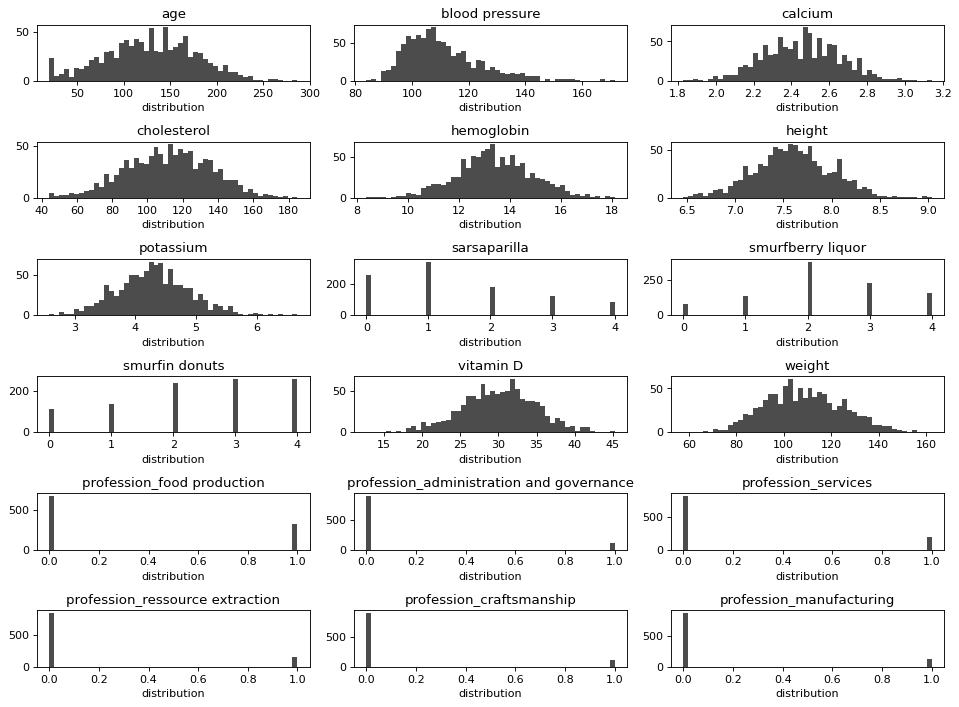

In [122]:
_, number_features = X_train.shape
features_names = X_train.columns.tolist()

# Set up the figure for subplots
fig = plt.figure(figsize=(12, 10), dpi=80)

# Generate histograms for each feature to show distribution
for i, idx in enumerate(range(number_features)):
    plt.subplot(number_features // 3 + 1, 3, i + 1)
    plt.hist(X_train.iloc[:, idx], bins=50, alpha=0.7, color='black')
    plt.xlabel("distribution")
    plt.title(f"{features_names[idx]}")

plt.tight_layout()
plt.show()

### Transformations
Applying a Box-Cox transformation should give us a Gaussian distribution did not work and gave atrocious results.

In [123]:
# gaussian_transformer = PowerTransformer(method='box-cox')
# X_train[['blood pressure']] = gaussian_transformer.fit_transform(X_train[['blood pressure']])

### Mitigating the impact of outliers
We are scaling the features using MinMax to reduce the impact of very high/very low values

In [124]:
ordinal_scaler = MinMaxScaler()
X_train[ordinal_categories] = pd.DataFrame(ordinal_scaler.fit_transform(X_train[ordinal_categories]))
X_test[ordinal_categories] = pd.DataFrame(ordinal_scaler.transform(X_test[ordinal_categories]))

normal_scaler = StandardScaler()
X_train[normally_distributed_categories] = pd.DataFrame(normal_scaler.fit_transform(X_train[normally_distributed_categories]))
X_test[normally_distributed_categories] = pd.DataFrame(normal_scaler.transform(X_test[normally_distributed_categories]))

### Impact of standardization

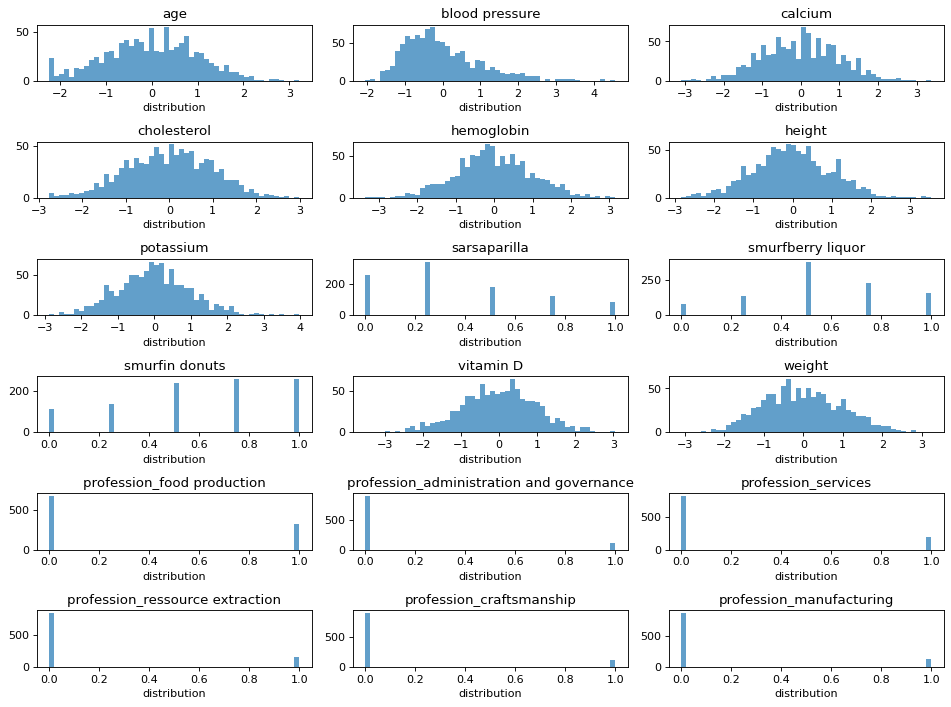

In [125]:
_, number_features = X_train.shape
features_names = X_train.columns.tolist()

# Set up the figure for subplots
fig = plt.figure(figsize=(12, 10), dpi=80)

# Generate histograms for each feature to show distribution
for i, idx in enumerate(range(number_features)):
    plt.subplot(number_features // 3 + 1, 3, i + 1)
    plt.hist(X_train.iloc[:, idx], bins=50, alpha=0.7)
    plt.xlabel("distribution")
    plt.title(f"{features_names[idx]}")

plt.tight_layout()
plt.show()

### Processed data anaylsis

In [126]:
X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 18 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   age                                       999 non-null    float64
 1   blood pressure                            999 non-null    float64
 2   calcium                                   999 non-null    float64
 3   cholesterol                               999 non-null    float64
 4   hemoglobin                                999 non-null    float64
 5   height                                    999 non-null    float64
 6   potassium                                 999 non-null    float64
 7   sarsaparilla                              999 non-null    float64
 8   smurfberry liquor                         999 non-null    float64
 9   smurfin donuts                            999 non-null    float64
 10  vitamin D                             

,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,profession_food production,profession_administration and governance,profession_services,profession_ressource extraction,profession_craftsmanship,profession_manufacturing
0,-1.024993,-0.400520,-1.361795,-1.565069,-0.558922,0.331238,-0.661149,0.25,0.75,0.50,-0.615919,-0.962435,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.147467,-1.225008,1.110102,-0.458686,-0.512067,0.306468,0.394345,0.25,0.25,0.75,-1.310925,-0.169138,1.0,0.0,0.0,0.0,0.0,0.0
2,1.118310,0.040415,0.813474,-0.487683,-1.408993,-0.362331,-1.314551,1.00,0.50,0.00,-0.040114,-0.987849,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.800456,-0.858066,1.406730,0.532526,0.893562,-0.387101,-0.862196,0.25,0.50,0.75,0.266982,0.209054,0.0,1.0,0.0,0.0,0.0,0.0
4,0.424288,0.261637,0.813474,0.711818,0.010023,0.504630,-1.951198,0.00,0.50,0.75,0.303348,0.010579,0.0,0.0,1.0,0.0,0.0,0.0


### Correlation
The result here is not very satisfactory. It seams like it should be > 0.8 to really speak of feature highly correlated.

Highly correlated features (correlation > 0.6): ['weight', 'smurfin donuts', 0.6312939771448425]


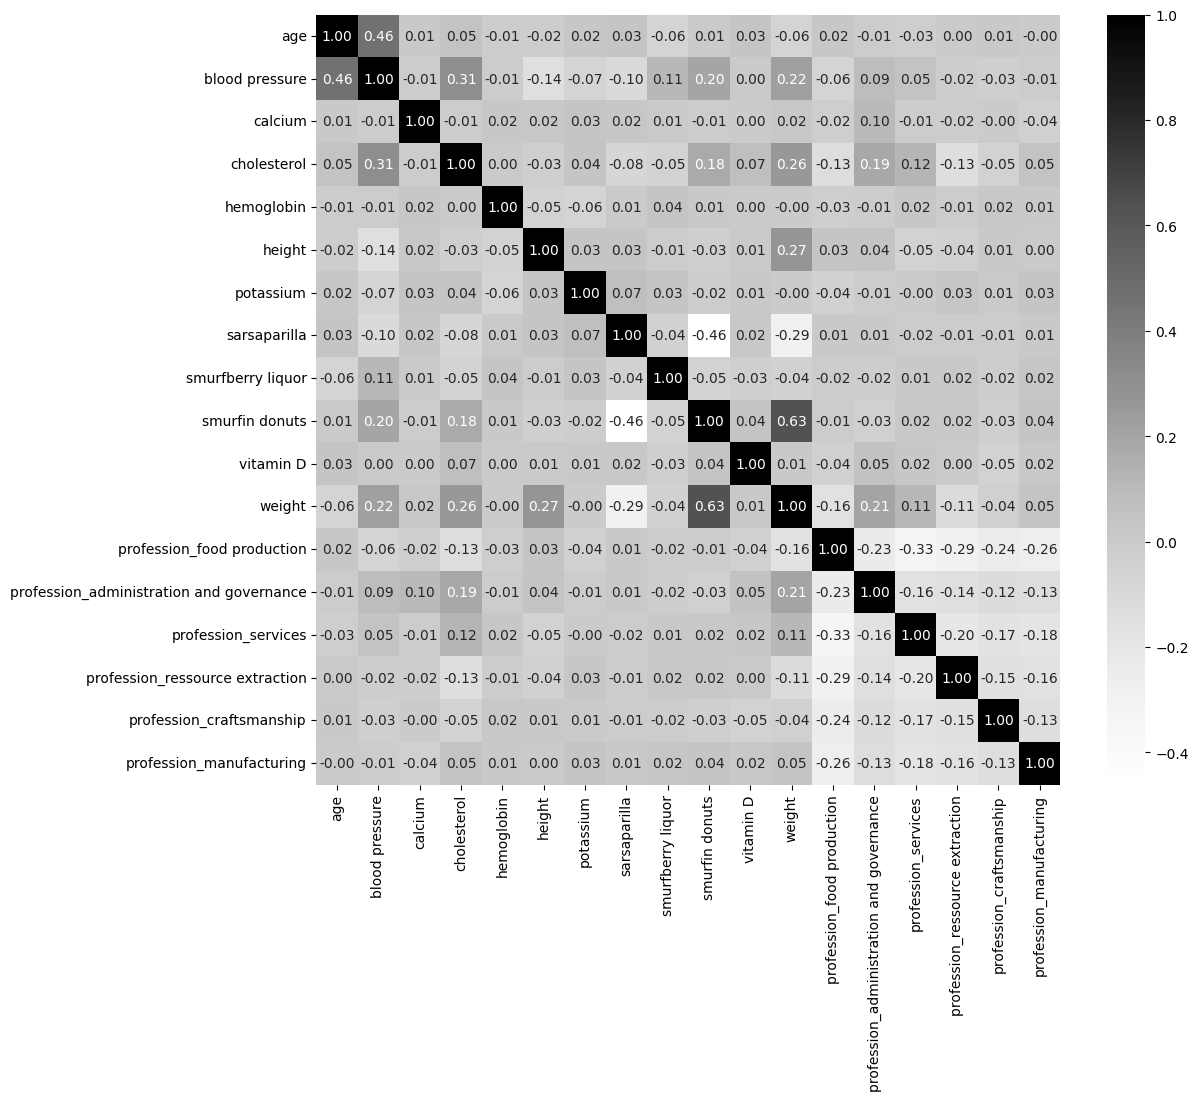

In [127]:
correlation_matrix = X_train.corr()
high_correlation_threshold = 0.6
highly_correlated_features = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if i != j and abs(correlation_matrix.iloc[i, j]) > high_correlation_threshold:
            highly_correlated_features += ([correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]])

print(f'Highly correlated features (correlation > {high_correlation_threshold}): {highly_correlated_features}')

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Greys', fmt=".2f")
plt.show()

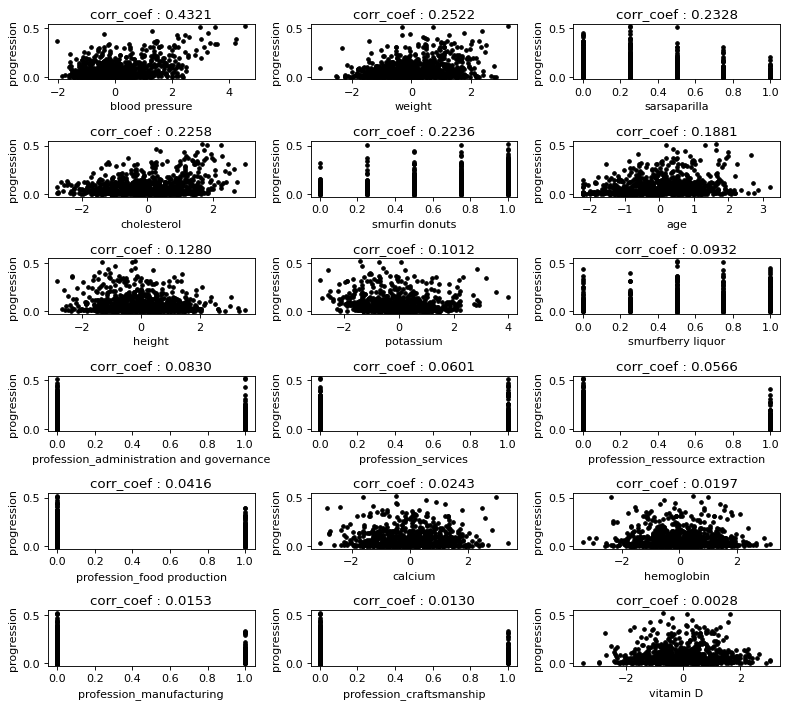

In [128]:
_, number_features = X_train.shape
features_names = X_train.columns.tolist()

corr_coef = np.corrcoef(X_train, y_train, rowvar=False)[-1, :number_features]
corr_coef_order = np.argsort(np.abs(corr_coef))[::-1]
fig = plt.figure(figsize=(10, 10), dpi=80)

for i, idx in enumerate(corr_coef_order):
    plt.subplot(number_features // 3 + 1, 3, i + 1)
    plt.scatter(X_train.iloc[:, idx], y_train, s=10, color='black')
    plt.xlabel(features_names[idx])
    plt.ylabel("progression")
    plt.title(f"corr_coef : {abs(corr_coef[idx]):.4f}")
plt.tight_layout()
plt.show()

### Outliers detection & spread and sparsity of the data
We can see that through transformation and standardization, we did improve the impact of outliers by a significant amount.

In [129]:
z_scores = np.abs(stats.zscore(X_train))
outliers = np.where(z_scores > 3)
outlier_indices = np.unique(outliers[0])
print(f"Percentage of outliers (Z-score method): {len(outlier_indices) / X_train.shape[0] * 100:.2f}%")

Percentage of outliers (Z-score method): 2.90%


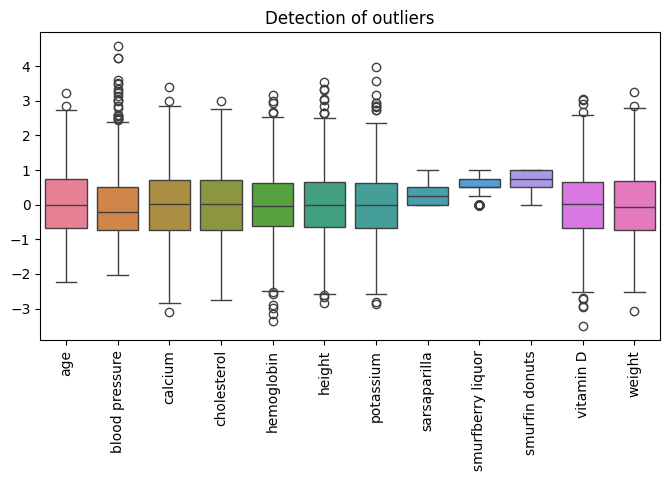

In [130]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=X_train.iloc[:, :12])
plt.title('Detection of outliers')
plt.xticks(rotation=90)
plt.show()